In [1]:
import pandas as pd
import numpy as np
import os
import random
import scipy as sp
from sklearn.metrics import confusion_matrix

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# notes:
#v3.1: removing flights from not major airports.
#v3.3: remove the feature of MONTH da instead use the week of year
#v3.4: removed some extra fittings methods which were performing worse than others

### Load flights data. Can't handle all the data together, so I'm loading a specific number of random lines.
#I also load only specific columns sincs I think the other columns are not necessary for what I want to do.
Specifically, I want to predict whether a flight will be late or not. The only potencially useful column which I excluded from my data was day of the month, since extra 31 columns (1 for each day of the month) would be too much for my computer, though I can always implement it later
#note: in v3.3 I loaded "DAY" column, and later used it to calculate the # of week of the year. I next included this column in my calculations but removed the "MONTH" column since together with the "WEEK" column it became redundant.

In [2]:
# total number of datapoints = 5819078 

n = 5819078
#skip = sorted(random.sample(range(1,n),n-2000))
skip = random.sample(range(1,n),n-2000000)
flights = pd.read_csv('flights.csv',skiprows=skip,usecols = ['MONTH','DAY','DAY_OF_WEEK','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE',
                                                             'DEPARTURE_DELAY','ARRIVAL_DELAY','CANCELLED'],low_memory=False)
airports = pd.read_csv('airports.csv')
airlines = pd.read_csv('airlines.csv')
flights = flights.sample(frac=1).reset_index(drop=True)  # here I randomize rows so that data is not chronologically sorted

all_features = flights.columns.values
#all_features

### fixing airport data
Some of the airports were listed using 5 digit numbers instead of 3 letter code. The code below fixes that problem. I used code by Scott Cole as a template for this section (see the link below).
https://www.kaggle.com/srcole/fix-inconsistent-airport-codes

In [4]:
aircode1 = pd.DataFrame.from_csv('L_AIRPORT.csv')
aircode2 = pd.DataFrame.from_csv('L_AIRPORT_ID.csv')

# Format the airport codes
aircode1 = aircode1.reset_index()
aircode2 = aircode2.reset_index()
aircodes = pd.merge(aircode1,aircode2,on='Description')
aircode_dict = dict(zip(aircodes['Code_y'].astype(str),aircodes['Code_x']))

# Make sure all Origin and departing airports are strings
flights['ORIGIN_AIRPORT'] = flights['ORIGIN_AIRPORT'].values.astype(str)
flights['DESTINATION_AIRPORT'] = flights['DESTINATION_AIRPORT'].values.astype(str)

for i in range(len(flights)):
    if len(flights['ORIGIN_AIRPORT'][i]) != 3:
        to_replace = flights['ORIGIN_AIRPORT'][i]
        value = aircode_dict[flights['ORIGIN_AIRPORT'][i]]
        flights = flights.replace(to_replace, value)
for i in range(len(flights)):
    if len(flights['DESTINATION_AIRPORT'][i]) != 3:
        to_replace = flights['DESTINATION_AIRPORT'][i]
        value = aircode_dict[flights['DESTINATION_AIRPORT'][i]]
        flights = flights.replace(to_replace, value)

# Enter the name of the airport
Limid the analysis to the specific airport to improve results and reduce processing time.

In [5]:
Depart_airport = str(input("Specify the departure airport (three letters) or put ALL:  ")).upper()
if Depart_airport in list(flights['ORIGIN_AIRPORT']):
    flights = flights[flights['ORIGIN_AIRPORT']== Depart_airport]
else:
    print("incorrect airport code")
#flights = flights[flights['ORIGIN_AIRPORT']=='LAS']

Specify the departure airport (three letters) or put ALL:  IAH


## Creating a column describing whether the flight was late to arrivelate or got cancelled
Again, for simplicity, I decided to combine these two features. I also chose 60min threshhold arbitrarily

In [6]:
def late_or_cancelled(x):
#    if x['ARRIVAL_DELAY'] > 60:
    if x['CANCELLED'] == 1 or x['ARRIVAL_DELAY'] > 60:
        return 1
    else:
        return 0

flights['late or cancelled'] = flights.apply(late_or_cancelled,axis = 1)
flights = flights[flights['CANCELLED']==0]
#predictions = flights.apply(late_or_cancelled,axis = 1)

# A function to change column Day from 1-31 to 1-365
Later I will change this into a week of year. The reason is that individual days will be too much to account for since they will give 365 columns in the end, while the week of year will give only 52. This could also be too much, but I'll see. Technically I could even remove the month since the week of a year will account for the month as well.

In [7]:
days_in_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
def day_31_to_365(x):
    days_365 = days_in_month[:x['MONTH']-1].sum() + x['DAY']
    return days_365

# Calculate the number of week and use it instead of month
MONTH column becomes redundant after adding the column for week

In [8]:
flights['DAY'] = flights.apply(day_31_to_365,axis = 1)
flights['WEEK'] = flights['DAY']//7
del flights['DAY']

## Since departure time is a categorical feature, I will devide it into 4 different sections
I will devide it into 6 hour sections stating with midnight

In [9]:
flights['SCHEDULED_DEPARTURE'] = np.ceil(flights['SCHEDULED_DEPARTURE']/600).apply(int)

## Getting rid of unnecessary data

In [10]:
del flights['ARRIVAL_DELAY']
del flights['DEPARTURE_DELAY']
del flights['CANCELLED']

## Plotting being late or not vs different features

In [11]:
Delay_vs_Day_of_Week = pd.DataFrame({'delays' : flights.groupby(['DAY_OF_WEEK'])['late or cancelled'].mean()}).reset_index()
Delay_vs_WEEK = pd.DataFrame({'delays' : flights.groupby(['WEEK'])['late or cancelled'].mean()}).reset_index()
Delay_vs_AIRLINE = pd.DataFrame({'delays' : flights.groupby(['AIRLINE'])['late or cancelled'].mean()})#.reset_index()
Delay_vs_SCHEDULED_DEPARTURE = pd.DataFrame({'delays' : flights.groupby(['SCHEDULED_DEPARTURE'])['late or cancelled'].mean()}).reset_index()

#Delay_vs_Day_of_Week.plot(x='DAY_OF_WEEK', y='delays')
#Delay_vs_Day_of_Week['delays'].hist(hold=None)

<Container object of 3 artists>

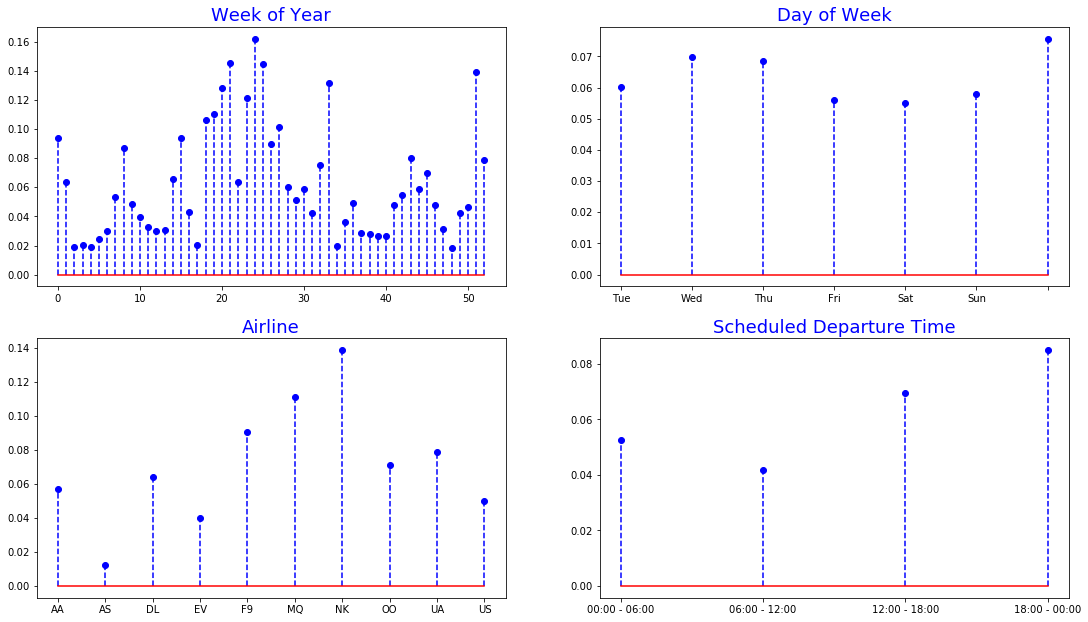

In [12]:
fig = plt.figure(figsize=(18.5, 10.5))
#fig.text(0.5, 0.5, 'Axes 1', ha='center', va='center', size=48, alpha=.5)
sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('Week of Year', fontsize=18, color="blue") # non OOP: plt.title('The function f')
sub1.stem(Delay_vs_WEEK['WEEK'], Delay_vs_WEEK['delays'], linefmt='b--', markerfmt='bo', basefmt='r-')

sub2 = fig.add_subplot(222)
sub2.set_title('Day of Week', fontsize=18, color="blue")
sub2.stem(Delay_vs_Day_of_Week['DAY_OF_WEEK'], Delay_vs_Day_of_Week['delays'], linefmt='b--', markerfmt='bo', basefmt='r-')
sub2.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

sub3 = fig.add_subplot(223)
sub3.set_title('Airline', fontsize=18, color="blue")
sub3.stem(range(len(Delay_vs_AIRLINE)), Delay_vs_AIRLINE['delays'], linefmt='b--', markerfmt='bo', basefmt='r-')
sub3.set_xticks(range(len(Delay_vs_AIRLINE)))
sub3.set_xticklabels(Delay_vs_AIRLINE.index)

sub4 = fig.add_subplot(224)
sub4.set_title('Scheduled Departure Time', fontsize=18, color="blue")
sub4.set_xticks([0, 1, 2, 3])
sub4.set_xticklabels(['00:00 - 06:00','06:00 - 12:00','12:00 - 18:00','18:00 - 00:00'])
sub4.stem(range(len(Delay_vs_SCHEDULED_DEPARTURE)), Delay_vs_SCHEDULED_DEPARTURE['delays'], linefmt='b--', markerfmt='bo', basefmt='r-')
#plt.tight_layout()
#plt.show()

# Removing flights from not major airports (Currently disabled)
This section allows to use the data from a specific number of airports, allowing to exclude for example airports with low number of flights which could mess with the statistics.

## This section is not currently being used for my calculations

max_Airports = 15  # max number of airports to be analyzed
ORIGIN_AIRPORTs = set(flights.groupby(['ORIGIN_AIRPORT'])['late or cancelled'].sum().sort_values(ascending=False)[0:max_Airports].index.tolist())
DESTINATION_AIRPORT = set(flights.groupby(['DESTINATION_AIRPORT'])['late or cancelled'].sum().sort_values(ascending=False)[0:max_Airports].index.tolist())
airports = ORIGIN_AIRPORTs | DESTINATION_AIRPORT

print(flights.shape)

#flights = flights[(flights['ORIGIN_AIRPORT'].isin(airports))]# & (flights['DESTINATION_AIRPORT'].isin(airports))]

## Correcting for a bias in being late vs not being late
Typically, there is much higher number of flights which were not late or cancelled than the ones that were. This creates an imbalance later when trying to classify or fit the data. So I'm getting rid of random rows where the plane was not late.
This way the number of rows where flights['late or cancelled']=1 or not is approximately the same. This should make predictions more accurate.

In [13]:
num_late = sum(flights['late or cancelled'])

flights_on_time = flights[flights['late or cancelled']==0]

flights_orig = flights.copy()

flights_on_time = flights_on_time.sample(frac=num_late/flights.shape[0]).reset_index(drop=True)
flights_on_time.shape
flights = pd.concat([flights[flights['late or cancelled']==1],flights_on_time])
flights = flights.sample(frac=1).reset_index(drop=True)

## Converting categorical values to sparce matrixes
At this point, all of the features are categorical, so I need to convert them into sparce matrixes using LabelBinarizer.
I tried to do this using pipelines, but it didn't quite work. Apparently, eventhough fit_transform was working just fine for the pipeline, just fit didn't work. I need just fit alone so that later I can apply it to data for which I'll want to make a prediction.

In [14]:
from sklearn.preprocessing import LabelBinarizer

WEEK_LabBin = LabelBinarizer()
WEEK_LabBin.fit(flights_orig['WEEK'])
WEEK_binarized = np.array(WEEK_LabBin.transform(flights['WEEK']))
WEEK_binarized_orig = np.array(WEEK_LabBin.transform(flights_orig['WEEK']))


DAY_OF_WEEK_LabBin = LabelBinarizer()
DAY_OF_WEEK_LabBin.fit(flights_orig['DAY_OF_WEEK'])
DAY_OF_WEEK_binarized = np.array(DAY_OF_WEEK_LabBin.transform(flights['DAY_OF_WEEK']))
DAY_OF_WEEK_binarized_orig = np.array(DAY_OF_WEEK_LabBin.transform(flights_orig['DAY_OF_WEEK']))


AIRLINE_LabBin = LabelBinarizer()
AIRLINE_LabBin.fit(flights_orig['AIRLINE'])
AIRLINE_binarized = np.array(AIRLINE_LabBin.transform(flights['AIRLINE']))
AIRLINE_binarized_orig = np.array(AIRLINE_LabBin.transform(flights_orig['AIRLINE']))


ORIGIN_AIRPORT_LabBin = LabelBinarizer()
ORIGIN_AIRPORT_LabBin.fit(flights_orig['ORIGIN_AIRPORT'])
ORIGIN_AIRPORT_binarized = np.array(DAY_OF_WEEK_LabBin.transform(flights['ORIGIN_AIRPORT']))
ORIGIN_AIRPORT_binarized_orig = np.array(DAY_OF_WEEK_LabBin.transform(flights_orig['ORIGIN_AIRPORT']))


DESTINATION_AIRPORT_LabBin = LabelBinarizer()
DESTINATION_AIRPORT_LabBin.fit(flights_orig['DESTINATION_AIRPORT'])
DESTINATION_AIRPORT_binarized = np.array(DESTINATION_AIRPORT_LabBin.transform(flights['DESTINATION_AIRPORT']))
DESTINATION_AIRPORT_binarized_orig = np.array(DESTINATION_AIRPORT_LabBin.transform(flights_orig['DESTINATION_AIRPORT']))


SCHEDULED_DEPARTURE_LabBin = LabelBinarizer()
SCHEDULED_DEPARTURE_LabBin.fit(flights_orig['SCHEDULED_DEPARTURE'])
SCHEDULED_DEPARTURE_binarized = np.array(SCHEDULED_DEPARTURE_LabBin.transform(flights['SCHEDULED_DEPARTURE']))
SCHEDULED_DEPARTURE_binarized_orig = np.array(SCHEDULED_DEPARTURE_LabBin.transform(flights_orig['SCHEDULED_DEPARTURE']))


# flights_binarized will contain all data in sparce matrix form
flights_binarized = np.concatenate((WEEK_binarized,DAY_OF_WEEK_binarized,AIRLINE_binarized,ORIGIN_AIRPORT_binarized,
                                    DESTINATION_AIRPORT_binarized,SCHEDULED_DEPARTURE_binarized),axis=1)
flights_binarized_orig = np.concatenate((WEEK_binarized_orig,DAY_OF_WEEK_binarized_orig,AIRLINE_binarized_orig,ORIGIN_AIRPORT_binarized_orig,
                                    DESTINATION_AIRPORT_binarized_orig,SCHEDULED_DEPARTURE_binarized_orig),axis=1)

print(flights_binarized.shape)
print(flights_binarized_orig.shape)


(6645, 198)
(54251, 198)


# split into test and training set

In [15]:
# splitting data into test and training sets
from sklearn.model_selection import train_test_split

train_set, test_set, train_set_target, test_set_target = train_test_split(flights_binarized, flights['late or cancelled'], test_size = 0.4, random_state=42)

# Random forest search

In [16]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_jobs=-1)
forest_reg.fit(train_set,train_set_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [17]:
confusion_matrix(train_set_target,(forest_reg.predict(train_set)).round())

array([[1919,   33],
       [  80, 1955]])

In [18]:
confusion_matrix(test_set_target,(forest_reg.predict(test_set)).round())

array([[854, 408],
       [510, 886]])

# GridSearch for RandomForest
Random Forest did the best so far, so I'll try gridsearch to get the best conditions for random forest model
#if I use all of the data instead of a single airport, the best numbers were [{'n_estimators': [150],'max_features':[50],'max_depth':[30]}]

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [75, 100],'max_features':[10, 20],'max_depth':[20, 30]}]
forest_reg = RandomForestRegressor(n_jobs=-1)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_set,train_set_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [75, 100], 'max_features': [10, 20], 'max_depth': [20, 30]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

# Use PICKLE to save results of the grid search

In [20]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(grid_search, open(filename, 'wb'))

#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)

# Confusion Matrix for Training set

In [21]:
# confusion matrix for training set
confusion_matrix(train_set_target,(grid_search.predict(train_set)).round())

array([[1789,  163],
       [ 135, 1900]])

In [22]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features=20, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Confusion Matrix for Test set

In [23]:
# confusion matrix for test set
confusion_matrix(test_set_target,(grid_search.predict(test_set)).round())

array([[773, 489],
       [403, 993]])

predictions = grid_search.predict(train_set)
grid_reg_results = pd.DataFrame({'True':train_set_target, 'predict':predictions})

grid_reg_results[grid_reg_results['predict']>0.8]['True'].sum()/grid_reg_results[grid_reg_results['predict']>0.8]['True'].shape[0]

# Create column "Comparison" to show which results is true/false pos/neg
True pos = 1, True neg = 2, False pos = 3, false neg = 4

In [24]:
def comparison_col(x):
    # True pos = 1, True neg = 2, False pos = 3, false neg = 4
    if (x['True'] == 1) & (x['predict'] > 0.5):
        return 1
    elif (x['True'] == 0) & (x['predict'] < 0.5):
        return 2
    elif (x['True'] == 0) & (x['predict'] > 0.5):
        return 3
    elif (x['True'] == 1) & (x['predict'] < 0.5):
        return 4

In [25]:
predictions = grid_search.predict(train_set)
grid_reg_results = pd.DataFrame({'True':train_set_target, 'predict':predictions})

grid_reg_results['Comparison'] = grid_reg_results.apply(comparison_col, axis = 1)

(0, 1)

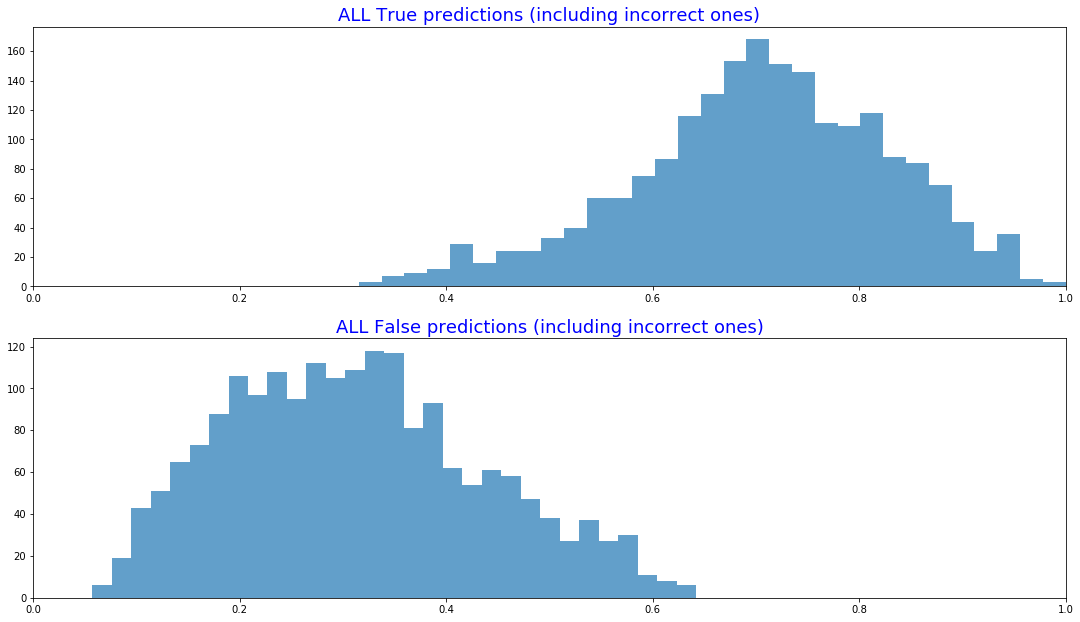

In [26]:
fig = plt.figure(figsize=(18.5, 10.5))
sub1 = fig.add_subplot(211) # instead of plt.subplot(2, 2, 1)
sub1.set_title('ALL True predictions (including incorrect ones)', fontsize=18, color="blue")
sub1.hist(grid_reg_results[grid_reg_results['True']==1]['predict'],alpha=0.7, bins=31)
sub1.set_xlim([0, 1])

sub2 = fig.add_subplot(212)
sub2.set_title('ALL False predictions (including incorrect ones)', fontsize=18, color="blue")
sub2.hist(grid_reg_results[grid_reg_results['True']==0]['predict'],alpha=0.7, bins=31)
sub2.set_xlim([0, 1])

# Plotting histograms of my results
Blue color shows correctly predicted results, orange shows incorrect predictions.

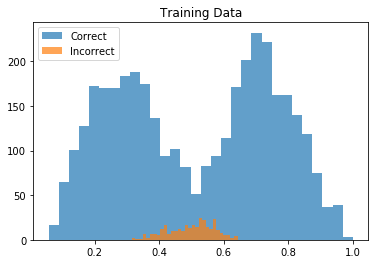

In [27]:
plt.hist(grid_reg_results[grid_reg_results['Comparison'].isin([1,2])]['predict'],alpha=0.7, bins=30,label='Correct')
plt.hist(grid_reg_results[grid_reg_results['Comparison'].isin([3,4])]['predict'],alpha=0.7, bins=30,label='Incorrect')
plt.legend(loc='upper left')
plt.title('Training Data')

In [28]:
test_predictions = grid_search.predict(test_set)
test_grid_reg_results = pd.DataFrame({'True':test_set_target, 'predict':test_predictions})
test_grid_reg_results['Comparison'] = test_grid_reg_results.apply(comparison_col, axis = 1)

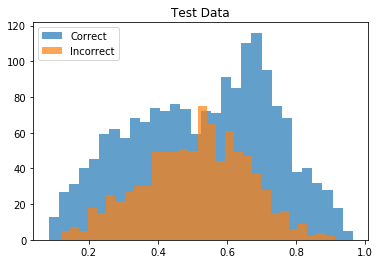

In [29]:
plt.hist(test_grid_reg_results[test_grid_reg_results['Comparison'].isin([1,2])]['predict'],alpha=0.7, bins=30,label='Correct')
plt.hist(test_grid_reg_results[test_grid_reg_results['Comparison'].isin([3,4])]['predict'],alpha=0.7, bins=30,label='Incorrect')
plt.legend(loc='upper left')
plt.title('Test Data')

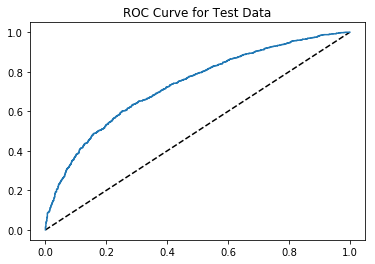

In [30]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, _ = roc_curve(test_set_target, test_predictions)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.title('ROC Curve for Test Data')

# modifying original flights data before balancing late vs. not_late
Earlier I exluded big chunk of data to correct for bias, but now I want to see how my predictions look for all the data together. 

In [31]:
orig_predictions = grid_search.predict(flights_binarized_orig)
orig_target = flights_orig['late or cancelled']
orig_grid_reg_results = pd.DataFrame({'True':orig_target, 'predict':orig_predictions})
orig_grid_reg_results['Comparison'] = orig_grid_reg_results.apply(comparison_col, axis = 1)

(0, 200)

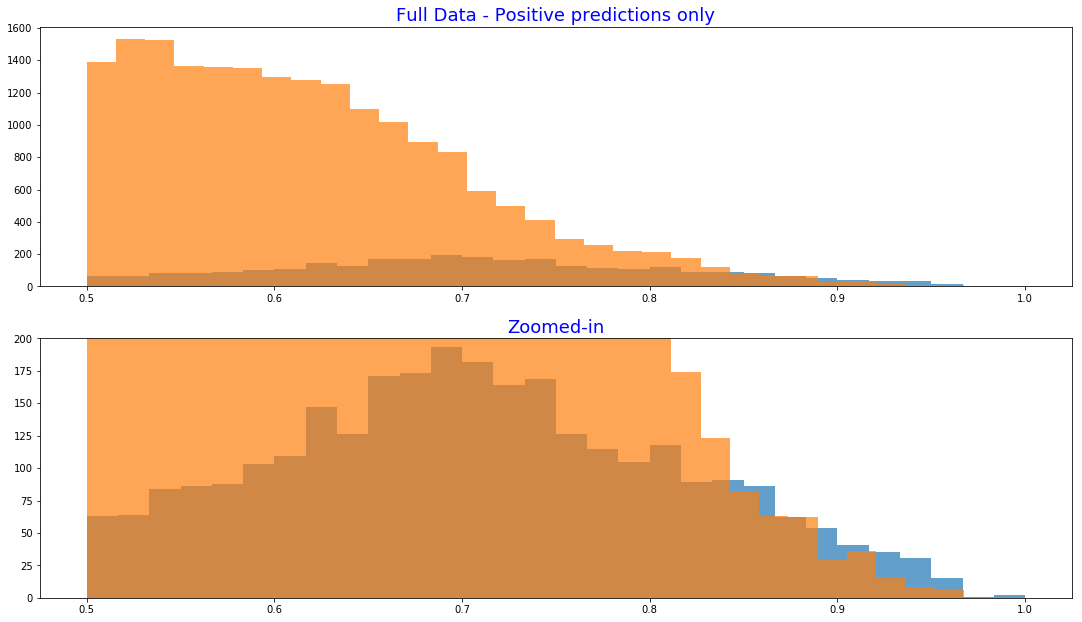

In [38]:
fig = plt.figure(figsize=(18.5, 10.5))
sub1 = fig.add_subplot(211) # instead of plt.subplot(2, 2, 1)
sub1.set_title('Full Data - Positive predictions only', fontsize=18, color="blue")
sub1.hist(orig_grid_reg_results[orig_grid_reg_results['Comparison'].isin([1])]['predict'],alpha=0.7, bins=30,label='True Positive')
sub1.hist(orig_grid_reg_results[orig_grid_reg_results['Comparison'].isin([3])]['predict'],alpha=0.7, bins=30,label='False Positive')
#sub1.set_xlim([0, 1])

sub2 = fig.add_subplot(212)
sub2.set_title('Zoomed-in', fontsize=18, color="blue")
sub2.hist(orig_grid_reg_results[orig_grid_reg_results['Comparison'].isin([1])]['predict'],alpha=0.7, bins=30,label='True Positive')
sub2.hist(orig_grid_reg_results[orig_grid_reg_results['Comparison'].isin([3])]['predict'],alpha=0.7, bins=30,label='False Positive')
sub2.set_ylim([0, 200])
#sub1.set_xlim([0, 1])

In [33]:
confusion_matrix(orig_target,(orig_predictions).round())

array([[31557, 19263],
       [  538,  2893]])

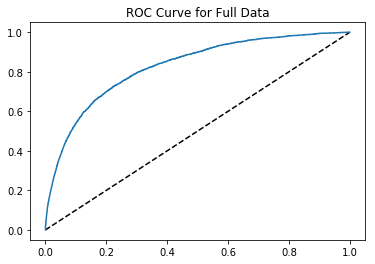

In [39]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, _ = roc_curve(orig_target, orig_predictions)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.title('ROC Curve for Full Data')

# Short Summary
While the ROC curve looks quite good, you can see from the histogram of the full data that the since there is much higher number of instances where the flights were neither delayed more than an hour, not cancelled (as expected), it is hard to make good predictions. It can also be seen in the confusion matrix.

Nevertheless, this script can be used to alert passengers regarding higher-than-usual chance of their flights being delayed to cancelled by using predictions with score higher than 0.85.